In [4]:
!pip install datasets

In [5]:
from transformers import (
  AutoTokenizer,
  BertTokenizer,
  EvalPrediction,
  AutoModelForSequenceClassification,
  Trainer,
  TrainingArguments,
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

In [6]:
file_path = 'data/Noticias.xlsx'
df_news = pd.read_excel('data/Noticias.xlsx', usecols='B:F')
df_news.dropna(inplace=True)
df_news = df_news[df_news['Etiqueta'].isin([
    'deportes',
    'cultura',
    'economia',
    'justicia',
    'politica',
    'tecnosfera',
    'salud'
])]
df_news.shape

(2386, 5)

In [7]:
df_preprocessed = df_news.copy()

In [8]:
df_preprocessed['unified_text'] = 'Título: ' + df_preprocessed['Título'] + '. Resumen: ' + df_preprocessed['info'] + '. Contenido: ' + df_preprocessed['contenido'] + '.'
df_preprocessed.head(2)

,Enlaces,Título,info,contenido,Etiqueta,unified_text
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,"Título: Al interior de, aparte, roquero, rock ..."
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,Título: Antonina Canal: 20 años de danza orien...


In [9]:
def preprocess_text(text):
    stripped = text.strip()
    cleaned = re.sub(r'[\n\t]+', ' ', stripped)
    cleaned = re.sub(r'\s{2,}', ' ', cleaned)
    cleaned = re.sub(r'\.{2,}', '.', cleaned)
    return cleaned

In [10]:
df_preprocessed['cleaned_text'] = df_preprocessed['unified_text'].apply(preprocess_text)
df_preprocessed.head(2)

,Enlaces,Título,info,contenido,Etiqueta,unified_text,cleaned_text
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,"Título: Al interior de, aparte, roquero, rock ...","Título: Al interior de, aparte, roquero, rock ..."
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,Título: Antonina Canal: 20 años de danza orien...,Título: Antonina Canal: 20 años de danza orien...


In [11]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
  model_id,
  problem_type="multi_label_classification",
  num_labels=1
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
df_preprocessed['input_ids'] = df_preprocessed['cleaned_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (1165 > 512). Running this sequence through the model will result in indexing errors


In [14]:
max_len = 512
df_preprocessed['input_ids'] = df_preprocessed['input_ids'].apply(lambda x: x[:max_len] + [0]*(max_len-len(x)) if len(x) < max_len else x[:max_len])

In [15]:
df_class = df_preprocessed.copy()

In [16]:
df_class['Etiqueta_class'] = [1 if x == "deportes" else 0 for x in df_class["Etiqueta"]]

In [17]:
X = df_class['input_ids'].tolist()
y = df_class['Etiqueta_class'].tolist()

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [39]:
train_encodings = torch.tensor(X_train)
val_encodings = torch.tensor(X_val)
train_labels = torch.tensor(np.array(y_train).reshape(-1, 1)).type(torch.FloatTensor)
val_labels = torch.tensor(np.array(y_val).reshape(-1, 1)).type(torch.FloatTensor)

In [40]:
train_masks = torch.tensor([[float(i != 0) for i in ii] for ii in X_train])
val_masks = torch.tensor([[float(i != 0) for i in ii] for ii in X_val])

# BERT

In [41]:
id2label = {0: "no_deportes", 1: "deportes"}
label2id = {"no_deportes": 0, "deportes": 1}

labels = list(id2label.keys())

In [48]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'eval_f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
      }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [50]:
batch_size = 8
metric_name = "loss"

args = TrainingArguments(
    "models",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    report_to='none'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [51]:
train_dataset = Dataset.from_dict({"input_ids": train_encodings, "attention_mask": train_masks, "labels": train_labels})
val_dataset = Dataset.from_dict({"input_ids": val_encodings, "attention_mask": val_masks, "labels": val_labels})

In [52]:
trainer = Trainer(
  model,
  args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  tokenizer=tokenizer,
)

trainer.train()

<ipython-input-52-644c23114b97>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.067337
2,No log,0.056207
3,0.104700,0.047222
4,0.104700,0.066997
5,0.027500,0.060362


TrainOutput(global_step=1195, training_loss=0.057656713709172844, metrics={'train_runtime': 235.2108, 'train_samples_per_second': 40.559, 'train_steps_per_second': 5.081, 'total_flos': 2510056931143680.0, 'train_loss': 0.057656713709172844, 'epoch': 5.0})

# Analysis

In [70]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [53]:
# Evaluar el modelo
results = trainer.evaluate()
print(results)

{'eval_loss': 0.04722176864743233, 'eval_runtime': 3.3825, 'eval_samples_per_second': 141.315, 'eval_steps_per_second': 17.738, 'epoch': 5.0}


In [54]:
y_pred = trainer.predict(val_dataset).predictions

In [57]:
y_pred = torch.sigmoid(torch.Tensor(y_pred)).numpy()
y_pred_res = (y_pred >= 0.5).astype(int)
y_pred_res = y_pred_res.flatten()
y_pred_res.shape

(478,)

In [66]:
y_pred_fin = y_pred_res.tolist()
len(y_val), len(y_pred_fin)

(478, 478)

In [67]:
print(classification_report(y_val, y_pred_fin))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       337
           1       0.99      0.99      0.99       141

    accuracy                           0.99       478
   macro avg       0.99      0.99      0.99       478
weighted avg       0.99      0.99      0.99       478



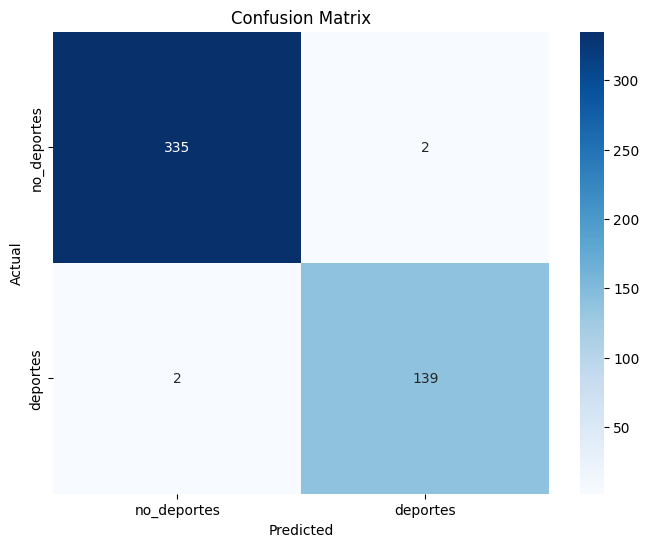

In [71]:
cm = confusion_matrix(y_val, y_pred_fin)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['no_deportes', 'deportes'],
            yticklabels=['no_deportes', 'deportes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Conclusions

Este modelo nos permitio enfocarnos en hacer un analisis comparativo sobre el entrenamiento y los resultados de entrenar un modelo desde 0 en relacion a un finetuning de un modelo ya existente, dando como resultado una mejora en el accuracy de por lo menos 10%.


Usando metricas basicas es posible ver que las diferencias son significativamente favorables para el modelo de finetuning.

En cuanto el proceso, los dos tienen ventajas y desventajas que nivelan la complejidad de llegar a un resultado, es decir no se ve una diferencia sustancial en que tan complejo es realizar el proceso de entrenamiento de modelos como LSTM o hacer finetuning a este modelo especifico.

En cuanto a uso de recursos, hacer finetuning de un modelo, consume sin dudas muchos mas recursos.